In [1]:
import os
import sys

sys.path.append("./")  # Adds higher directory to python modules path.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from data_pipeline import *
import numpy as np
import pandas as pd
from core.ODEDataset import  ODEDataset
from utils import cleaning

In [ ]:
print("Available devices:", tf.config.list_physical_devices())
logical_devices = tf.config.list_logical_devices()
print("Active logical devices:", logical_devices)

print("Version : ", tf.__version__)

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Active logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Version :  2.11.0


Let's load the dataset and  select the columns we want to use as features and labels.

## Constants & Parameters

In [3]:
BATCH_SIZE = 4096
Features = [
    #    'Education_level_HHH',
    'Education_level_HHH_Doctoral or equivalent level',
    'Education_level_HHH_Lower secondary education',
    "Education_level_HHH_Master's or equivalent level",
    'Education_level_HHH_No schooling',
    'Education_level_HHH_Not elsewhere classified',
    'Education_level_HHH_Other',
    'Education_level_HHH_Post-secondary non-tertiary education',
    'Education_level_HHH_Primary education',
    'Education_level_HHH_Secondary education',
    'Education_level_HHH_Short-cycle tertiary education',
    'Education_level_HHH_Upper secondary education',
    # 'Socio_status_HHH',
    'Socio_status_HHH_Employee', 'Socio_status_HHH_Employee farm',
    'Socio_status_HHH_Employee non-farm',
    # 'Socio_status_HHH_Employer',
    'Socio_status_HHH_Other', 'Socio_status_HHH_Own-account worker farm',
    'Socio_status_HHH_Own-account worker non-farm',
    'Socio_status_HHH_Unemployed',
    'Socio_status_HHH_Worker not classifiable by status',
    # 'Tariff_payment_frequency',
    'Tariff_payment_frequency_Every 3 months',
    'Tariff_payment_frequency_Every 6 months',
    'Tariff_payment_frequency_Monthly', 'Tariff_payment_frequency_No bill',
    'Tariff_payment_frequency_Other', 'Tariff_payment_frequency_Weekly',

    'HH_with_home_business_Yes',
    'HH_with_home_business_No',
    'HH_with_home_business_missing',

    'Ownership_motorized_vehicle_Yes',
    'Ownership_large_livestock_No',
    'Ownership_motorized_vehicle_missing',

    'Ownership_small_livestock_Yes',
    'Ownership_small_livestock_No',
    'Ownership_small_livestock_missing',

    'Ownership_large_livestock_Yes',
    'Ownership_large_livestock_No',
    'Ownership_large_livestock_missing',

    'Clean_fuel_Yes',
    'Clean_fuel_No',
    'Clean_fuel_missing',

    'Years_of_HHH_in_community',
    'Years_of_HHH_in_community_missing',

    'Dwelling_quality_index',
    'Dwelling_quality_index_missing',

    'Hours_available_electricity',
    'Hours_available_electricity_missing',

    'Measurement_age',
    'Measurement_age_missing',

    'Monthly_expenditure',
    'Monthly_expenditure_missing',

    'Number_of_rooms',
    'Number_of_rooms_missing',
    'Climate_zone_lev_1',
    'Climate_zone_lev_1_missing',

    'Climate_zone_lev_2',
    'Climate_zone_lev_2_missing',

    'Age_HHH',
    'Age_HHH_missing',

    'Number_adults',
    'Number_adults_missing'
]

FEATURE_NUM = len(Features)



In [4]:
# OUTPUT =  "Presence_refrigerator/freezer" # {1.0: 0.13849033063006863, 0.0: 0.8615096693699313}
OUTPUT =  "Presence_iron" # {0.0: 0.7690382552735073, 1.0: 0.23096174472649267}
# OUTPUT =  "Presence_fan" # {1.0: 0.25035427491733586, 0.0: 0.7496457250826641}
# OUTPUT =  "Presence_DVD_player" #  {0.0: 0.8856872933396316, 1.0: 0.11431270666036844}
# OUTPUT =  "Presence_radio/stereo" # {1.0: 0.23284005037783376, 0.0: 0.7671599496221663}
# OUTPUT =  "Presence_phone_charger" # {0.0: 0.7842976561219472, 1.0: 0.2157023438780528}
# OUTPUT =  "Presence_TV" # {0.0: 0.8220796266588887, 1.0: 0.17792037334111127}

## Dataset and Feature Selection

In [5]:
path ="./playground/data/dataset_normalized.csv"
dataset = ODEDataset("combined_dataset_cleaned")
dataset.from_csv(path)
dataset = dataset.apply(cleaning.remove_row(OUTPUT, -1))
dataset = add_one_hot_encoding(dataset)
df = dataset.to_dataframe()

In [6]:
features =df[Features]
target = df[OUTPUT]

In [ ]:
features.head()

,Education_level_HHH_Doctoral or equivalent level,Education_level_HHH_Lower secondary education,Education_level_HHH_Master's or equivalent level,Education_level_HHH_No schooling,Education_level_HHH_Not elsewhere classified,Education_level_HHH_Other,Education_level_HHH_Post-secondary non-tertiary education,Education_level_HHH_Primary education,Education_level_HHH_Secondary education,Education_level_HHH_Short-cycle tertiary education,...,Number_of_rooms,Number_of_rooms_missing,Climate_zone_lev_1,Climate_zone_lev_1_missing,Climate_zone_lev_2,Climate_zone_lev_2_missing,Age_HHH,Age_HHH_missing,Number_adults,Number_adults_missing
0,False,False,False,False,False,False,False,True,False,False,...,0.086957,0,0.188229,0,0.000000,1,0.0,1,34,0
1,False,False,False,False,False,False,False,True,False,False,...,0.086957,0,0.188229,0,0.000000,1,0.0,1,34,0
10,False,False,False,False,False,False,False,True,False,False,...,0.086957,0,0.188229,0,0.185917,0,0.0,1,44,0
11,False,False,False,False,False,False,False,True,False,False,...,0.086957,0,0.188229,0,0.185917,0,0.0,1,44,0
12,False,False,False,False,False,False,False,True,False,False,...,0.086957,0,0.188229,0,0.185917,0,0.0,1,44,0


In [8]:
x_train_val, x_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)

### Imbalanced Dataset Handling
We use Imbalanced learning library 
https://imbalanced-learn.org/stable/index.html

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# sampler = RandomUnderSampler()
sampler = SMOTE(random_state=412)
x_train, y_train = sampler.fit_resample(x_train, y_train )
print(x_train.shape, y_train.shape)

(8604, 60) (8604,)


<Axes: title={'center': 'Training target Distribution'}, ylabel='count'>

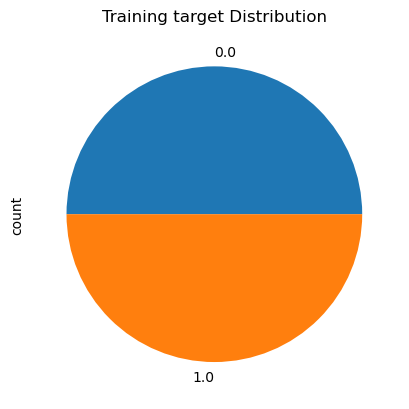

In [ ]:
y_train.value_counts().plot(kind='pie', title='Training target Distribution')



<Axes: title={'center': 'Validation target Distribution'}, ylabel='count'>

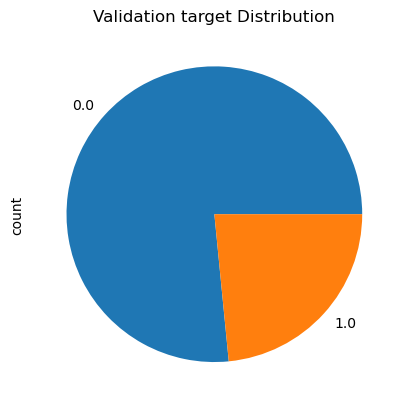

In [11]:
y_val.value_counts().plot(kind='pie', title='Validation target Distribution')

<Axes: title={'center': 'Testing target Distribution'}, ylabel='count'>

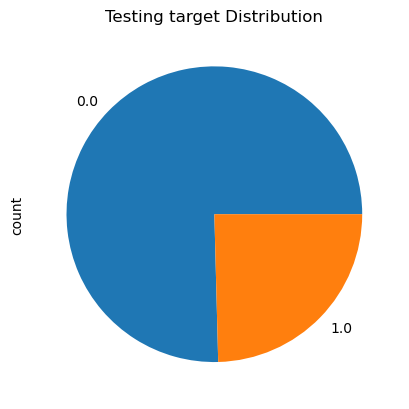

In [ ]:
y_test.value_counts().plot(kind='pie', title='Testing target Distribution')

In [13]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)

# x_val = scaler.transform(x_val)
# x_test = scaler.transform(x_test)

# x_train = np.clip(x_train, -5, 5)
# x_val = np.clip(x_val, -5, 5)
# x_test = np.clip(x_test, -5, 5)


In [14]:
# import seaborn as sns
# pos_df = pd.DataFrame(x_train[ y_train==1], columns=Features)
# neg_df = pd.DataFrame(x_train[y_train==0], columns=Features)

# sns.jointplot(x=pos_df['Dwelling_quality_index'], y=pos_df['Age_HHH'],
#               kind='hex', xlim=(-5,5), ylim=(-5,5))
# plt.suptitle("Positive distribution")

# sns.jointplot(x=neg_df['Dwelling_quality_index'], y=neg_df['Age_HHH'],
#               kind='hex', xlim=(-5,5), ylim=(-5,5))
# _ = plt.suptitle("Negative distribution")


In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
# train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(10010).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val.astype(np.float32), y_val.astype(np.float32)))
# val_ds = val_ds.map(normalize)
val_ds = val_ds.shuffle(10010).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), y_test.astype(np.float32)))
# test_ds = val_ds.map(normalize)


## Model

In [16]:
def residual_block(input_tensor, units, activation=tf.keras.layers.ReLU(),dropout=0.1, bn=True, regularizer=None):
    # First layer in the block
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    # Second layer in the block
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(x)
    if bn:
        
        x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dropout(dropout)(x)
    # Skip connection (adding input to output)
    x = tf.keras.layers.Add()([x, input_tensor])
    x = activation(x)  # Activation after addition
    return x

def layer_block(x, units, activation=tf.keras.layers.ReLU(),dropout=0.1, bn=True, regularizer=None):
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(x)
    
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Dropout(dropout)(x)
    x = activation(x)
    return x


In [17]:
THRESHOLD = 0.5
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.01)
LOSS = tf.keras.losses.BinaryCrossentropy()
EPOCHS = 1000

In [18]:
initializer = tf.keras.initializers.GlorotNormal(2771)  
regularizer = tf.keras.regularizers.l2(0.01)

units = 128
n_blocks = 8
dropout = 0.4
activation = tf.keras.layers.ReLU(
 
)

bn = True
# Input layer

input_tensor = tf.keras.layers.Input(shape=(FEATURE_NUM,))


first = layer_block(input_tensor, units, activation=activation,dropout=dropout, bn=bn, regularizer=regularizer)
x = layer_block(first, units, activation=activation,dropout=dropout, bn=bn, regularizer=regularizer)
for i in range(n_blocks):    
    x = layer_block(x, units, activation=activation,dropout=dropout, bn=bn, regularizer=regularizer)

x = tf.keras.layers.Add()([x, first])
# x = layer_block(x, units, activation=activation,
#                    dropout=dropout, bn=bn,
#                    regularizer=regularizer)

# Output layer  
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.Model(inputs=input_tensor, outputs=output)

model.compile(optimizer=OPTIMIZER, loss=LOSS, 
              metrics=[
                        tf.keras.metrics.BinaryAccuracy(name='accuracy', ),
                        tf.keras.metrics.Precision(name='precision', thresholds=THRESHOLD),
                        tf.keras.metrics.Recall(name='recall', thresholds=THRESHOLD),
                        tf.keras.metrics.FalsePositives(name='fp', thresholds=THRESHOLD),
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
                        ])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          7808        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128)         512         ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['batch_normalization[0][0]']

In [19]:
class_weight = {0: 2, 1: 1.0}  # Higher weight for the minority class (1)
PATIENCE = 100
monitor = 'val_auc'
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,  # Metric to monitor
    patience=PATIENCE,            # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    mode='max',

)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor,  # Metric to monitor
    factor=0.9,          # Reduce learning rate by this factor (90%)
    patience=50,          # Wait for 3 epochs of no improvement
    min_lr=1e-5,          # Minimum learning rate
)

CALLBACKS = [
    EARLY_STOPPING, 
    reduce_lr
]

history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=val_ds, 
                    class_weight=class_weight,
                    callbacks=CALLBACKS
                    )


Epoch 1/1000
3/3 [==============================] - 8s 350ms/step - loss: 12.4834 - accuracy: 0.5796 - precision: 0.6817 - recall: 0.2987 - fp: 600.0000 - auc: 0.6356 - prc: 0.6253 - val_loss: 8.4724 - val_accuracy: 0.8399 - val_precision: 0.7407 - val_recall: 0.4878 - val_fp: 56.0000 - val_auc: 0.8891 - val_prc: 0.6952 - lr: 0.0100
Epoch 2/1000
3/3 [==============================] - 0s 56ms/step - loss: 8.0467 - accuracy: 0.7589 - precision: 0.8440 - recall: 0.6353 - fp: 505.0000 - auc: 0.8778 - prc: 0.8314 - val_loss: 5.4305 - val_accuracy: 0.8242 - val_precision: 0.7662 - val_recall: 0.3598 - val_fp: 36.0000 - val_auc: 0.8815 - val_prc: 0.6774 - lr: 0.0100
Epoch 3/1000
3/3 [==============================] - 0s 63ms/step - loss: 5.2332 - accuracy: 0.8266 - precision: 0.8404 - recall: 0.8064 - fp: 659.0000 - auc: 0.8905 - prc: 0.8665 - val_loss: 3.4484 - val_accuracy: 0.8392 - val_precision: 0.6988 - val_recall: 0.5518 - val_fp: 78.0000 - val_auc: 0.9111 - val_prc: 0.6906 - lr: 0.0100

## Visualization & Evaluation

In [20]:
def draw_metric(history, metric):
        
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label=f'Training {metric}', color='blue', )
    plt.plot(val_metric, label=f'Validation {metric}', color='orange',)
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()
    

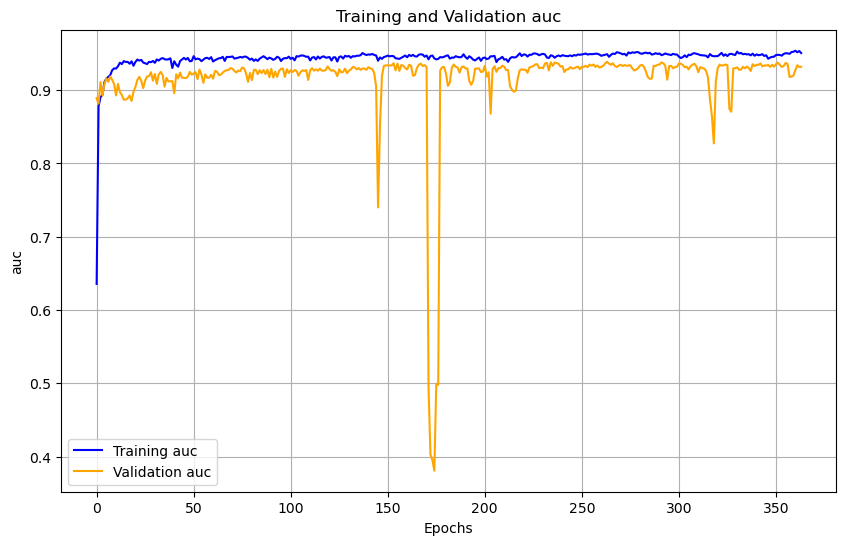

In [21]:
draw_metric(history, 'auc')

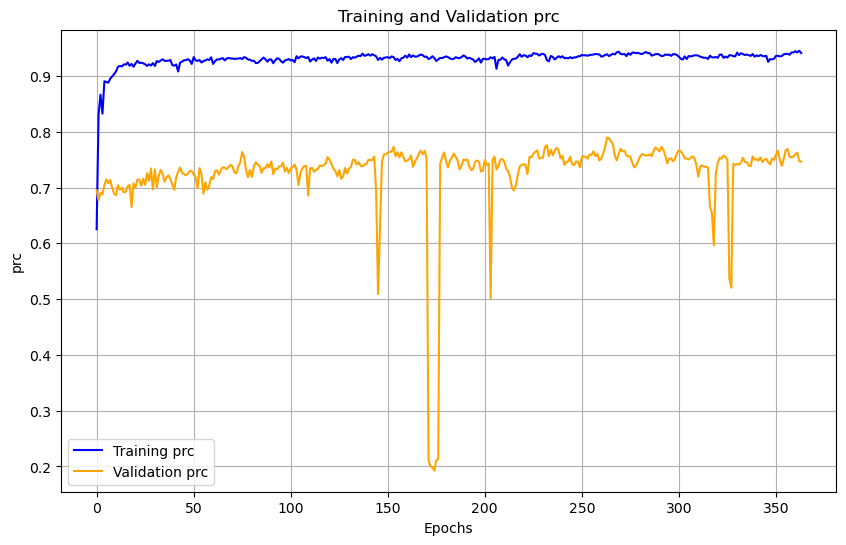

In [22]:
draw_metric(history, 'prc')

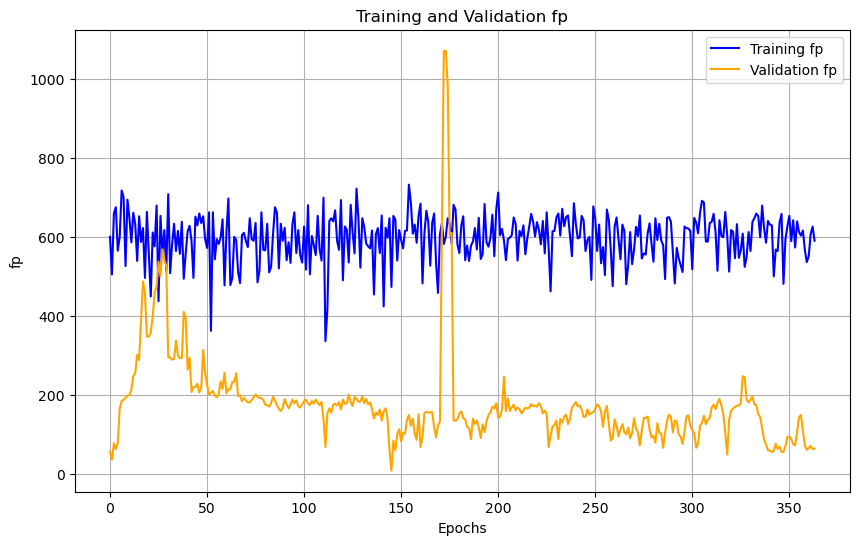

In [23]:
draw_metric(history, 'fp')

In [24]:
from sklearn.metrics import classification_report,  precision_score, recall_score, fbeta_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

def get_classification_report(x, y_true, threshold=0.5):
 
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return classification_report(y_true, y_pred)

def get_f2_score(x, y_true, beta = 2, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return fbeta_score(y_true, y_pred, beta=beta)

def get_precision(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return precision_score(y_true, y_pred)

def get_recall(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return recall_score(y_true, y_pred)

def get_auc(x, y_true):
    y_pred = model.predict(x, verbose=0)
    return roc_auc_score(y_true, y_pred)

def get_confusion_matrix(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  
    cm = confusion_matrix(y_pred, y_true)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

def get_precision_recall_curve(x, y_true):
    y_pred = model.predict(x, verbose=0)
    # y_pred = ((y_pred >= threshold).astype(int).flatten())  
    ticks = np.linspace(0, 1, 10)
    plt.xticks(ticks)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    plt.plot(thresholds, precision[:-1], label="Precision",)
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Precision-Recall vs. Threshold")
    plt.show()



<Figure size 1200x600 with 0 Axes>

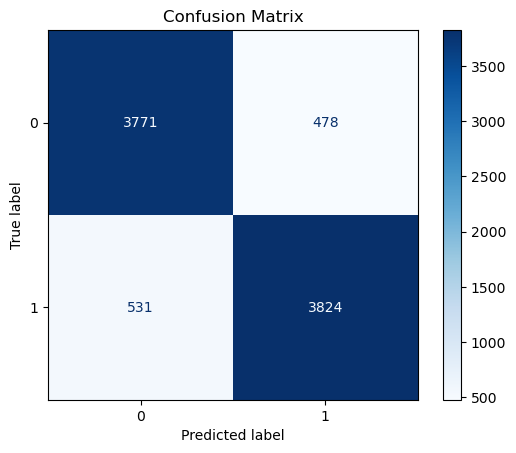

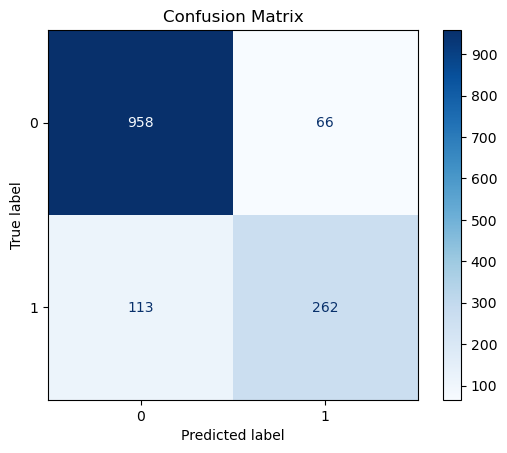

In [25]:

plt.figure(figsize=(12, 6))
x = x_train.astype(np.float32)
y = y_train.astype(np.float32)
get_confusion_matrix(x, y, THRESHOLD)

x = x_val.astype(np.float32)
y = y_val.astype(np.float32)
get_confusion_matrix(x, y, THRESHOLD)

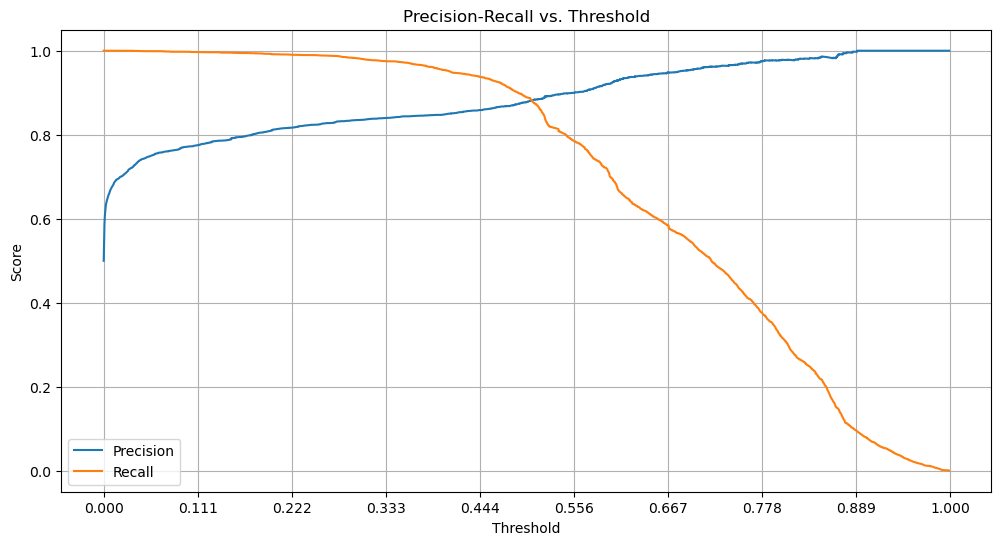

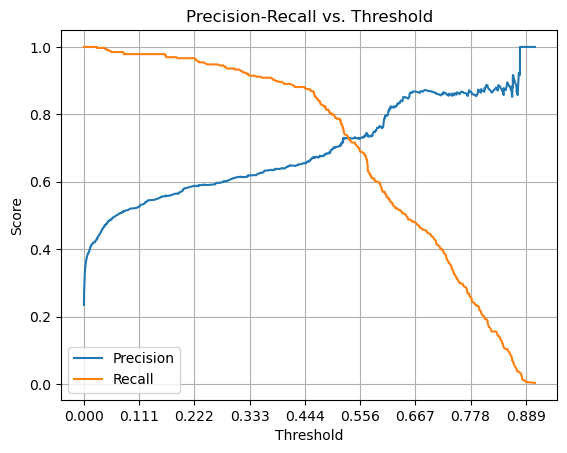

In [26]:

plt.figure(figsize=(12, 6))
plt.grid(True)
x = x_train.astype(np.float32)
y = y_train.astype(np.float32)
get_precision_recall_curve(x, y)
x = x_val.astype(np.float32)
y = y_val.astype(np.float32)
plt.grid(True)
get_precision_recall_curve(x, y)


In [27]:
THRESHOLD = 0.34

In [28]:


x = x_train.astype(np.float32)
y = y_train.astype(np.float32)
fb = get_f2_score(x, y, beta=2, threshold = THRESHOLD, )
pr = get_precision(x, y, THRESHOLD)
re = get_recall(x, y, THRESHOLD)
auc = get_auc(x, y)
print("Training")
print("F2 Score: ", fb)
print("Precision: ", pr)
print("Recall: ", re)
print("AUC: ", auc)
print(get_classification_report(x, y, THRESHOLD))

print("*" * 100)

x = x_val.astype(np.float32)
y = y_val.astype(np.float32)
fb = get_f2_score(x, y, beta=2, threshold = THRESHOLD, )
pr = get_precision(x, y, THRESHOLD)
re = get_recall(x, y, THRESHOLD)
auc = get_auc(x, y)
print("Validation")
print("F2 Score: ", fb)
print("Precision: ", pr)
print("Recall: ", re)
print("AUC: ", auc)
print(get_classification_report(x, y, THRESHOLD))


Training
F2 Score:  0.9447648224905388
Precision:  0.8408179631114675
Recall:  0.9748953974895398
AUC:  0.9539999126826505
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89      4302
         1.0       0.84      0.97      0.90      4302

    accuracy                           0.90      8604
   macro avg       0.91      0.90      0.89      8604
weighted avg       0.91      0.90      0.89      8604

****************************************************************************************************
Validation
F2 Score:  0.8351893095768375
Precision:  0.6198347107438017
Recall:  0.9146341463414634
AUC:  0.9387568035344219
              precision    recall  f1-score   support

         0.0       0.97      0.83      0.89      1071
         1.0       0.62      0.91      0.74       328

    accuracy                           0.85      1399
   macro avg       0.79      0.87      0.82      1399
weighted avg       0.89      0.85      0.86      139

In [38]:
import shap
# Create an explainer (for tree-based models)

# Randomly select 100 indices from x_train
x = x_train.astype(np.float32)
indices = np.random.choice(x.shape[0], size=1-0, replace=False)
# Use these indices to select rows from x_train
background = x_train[:299]

explainer = shap.DeepExplainer(model, background)

# Calculate SHAP values for the train set
shap_values = explainer.shap_values(x_train)

/home/awad/anaconda3/envs/nlp/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


AttributeError: Exception encountered when calling layer 'model' (type Functional).

'tuple' object has no attribute 'rank'

Call arguments received by layer 'model' (type Functional):
  • inputs=["     Education_level_HHH_Doctoral or equivalent level  \\\n0                                               False   \n1                                               False   \n2                                               False   \n3                                               False   \n4                                               False   \n..                                                ...   \n294                                             False   \n295                                             False   \n296                                             False   \n297                                             False   \n298                                             False   \n\n     Education_level_HHH_Lower secondary education  \\\n0                                            False   \n1                                            False   \n2                                            False   \n3                                             True   \n4                                             True   \n..                                             ...   \n294                                          False   \n295                                          False   \n296                                          False   \n297                                          False   \n298                                          False   \n\n     Education_level_HHH_Master's or equivalent level  \\\n0                                               False   \n1                                               False   \n2                                               False   \n3                                               False   \n4                                               False   \n..                                                ...   \n294                                             False   \n295                                             False   \n296                                             False   \n297                                             False   \n298                                             False   \n\n     Education_level_HHH_No schooling  \\\n0                               False   \n1                               False   \n2                                True   \n3                               False   \n4                               False   \n..                                ...   \n294                             False   \n295                             False   \n296                             False   \n297                             False   \n298                             False   \n\n     Education_level_HHH_Not elsewhere classified  Education_level_HHH_Other  \\\n0                                           False                      False   \n1                                           False                      False   \n2                                           False                      False   \n3                                           False                      False   \n4                                           False                      False   \n..                                            ...                        ...   \n294                                         False                      False   \n295                                         False                       True   \n296                                         False                       True   \n297                                         False                      False   \n298                                         False                       True   \n\n     Education_level_HHH_Post-secondary non-tertiary education  \\\n0                                                False           \n1                                                 True           \n2                                                False           \n3                                                False           \n4                                                False           \n..                                                 ...           \n294                                              False           \n295                                              False           \n296                                              False           \n297                                              False           \n298                                              False           \n\n     Education_level_HHH_Primary education  \\\n0                                     True   \n1                                    False   \n2                                    False   \n3                                    False   \n4                                    False   \n..                                     ...   \n294                                   True   \n295                                  False   \n296                                  False   \n297                                   True   \n298                                  False   \n\n     Education_level_HHH_Secondary education  \\\n0                                      False   \n1                                      False   \n2                                      False   \n3                                      False   \n4                                      False   \n..                                       ...   \n294                                    False   \n295                                    False   \n296                                    False   \n297                                    False   \n298                                    False   \n\n     Education_level_HHH_Short-cycle tertiary education  ...  Number_of_rooms  \\\n0                                                False   ...         0.086957   \n1                                                False   ...         0.043478   \n2                                                False   ...         0.108696   \n3                                                False   ...         0.065217   \n4                                                False   ...         0.065217   \n..                                                 ...   ...              ...   \n294                                              False   ...         0.065217   \n295                                              False   ...         0.043478   \n296                                              False   ...         0.108696   \n297                                              False   ...         0.065217   \n298                                              False   ...         0.043478   \n\n     Number_of_rooms_missing  Climate_zone_lev_1  Climate_zone_lev_1_missing  \\\n0                          0            0.564686                           0   \n1                          0            0.188229                           0   \n2                          0            0.188229                           0   \n3                          0            0.564686                           0   \n4                          0            0.564686                           0   \n..                       ...                 ...                         ...   \n294                        0            0.736150                           0   \n295                        0            0.369422                           0   \n296                        0            0.188229                           0   \n297                        0            0.525311                           0   \n298                        0            0.564686                           0   \n\n     Climate_zone_lev_2  Climate_zone_lev_2_missing   Age_HHH  \\\n0              0.000000                           1  0.303030   \n1              0.185917                           0  0.000000   \n2              0.000000                           1  0.616162   \n3              0.000000                           1  0.262626   \n4              0.000000                           1  0.282828   \n..                  ...                         ...       ...   \n294            0.000000                           1  0.393939   \n295            0.000000                           1  0.434343   \n296            0.000000                           1  0.606061   \n297            0.000000                           1  0.444444   \n298            0.000000                           1  0.363636   \n\n     Age_HHH_missing  Number_adults  Number_adults_missing  \n0                  0              2                      0  \n1                  1             41                      0  \n2                  0              2                      0  \n3                  0              1                      0  \n4                  0              1                      0  \n..               ...            ...                    ...  \n294                0              2                      0  \n295                0              2                      0  \n296                0              1                      0  \n297                0              5                      0  \n298                0              3                      0  \n\n[299 rows x 60 columns]"]
  • training=False
  • mask=None

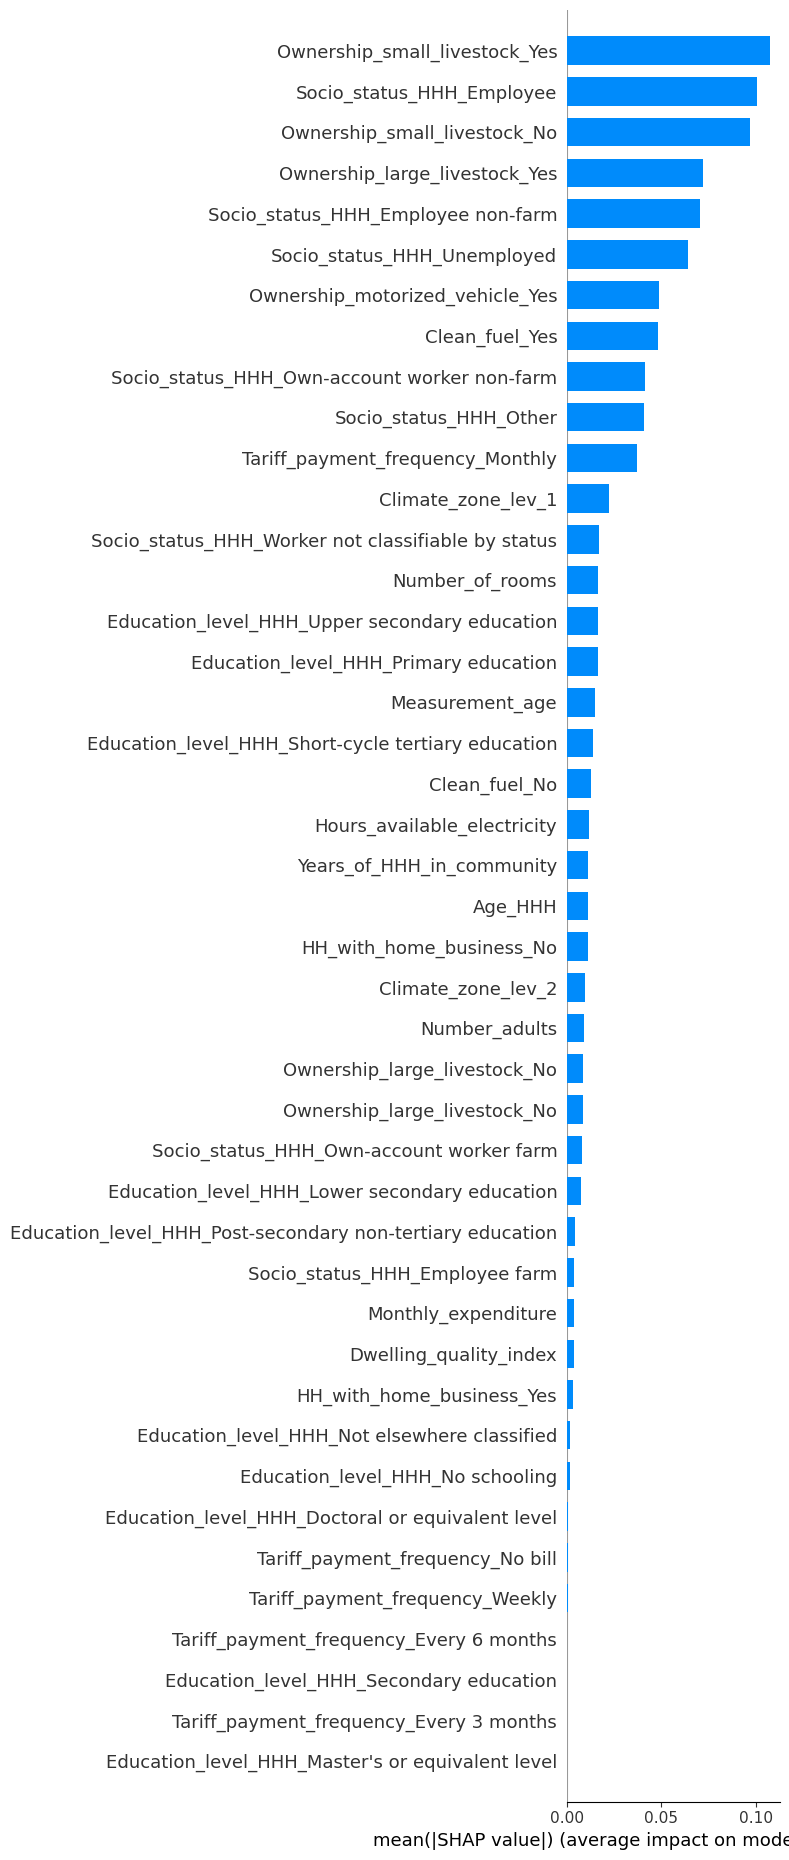

In [30]:
shap.summary_plot(shap_values.squeeze(axis=-1), features=Features, plot_type='bar', max_display=60)